# Imports

In [273]:
%matplotlib notebook
import pandas as pd
import string
from matplotlib import pyplot as plt
from matplotlib import mlab
import re
import requests
import json
import tqdm

## Explore the datasets


### Read in data

In [240]:
data = pd.read_table('./data/u.data', names=['UserId', 'ItemId', 'Rating', 'Timestamp'], index_col=[0,1])
item = pd.read_table('./data/u.item', sep='|', names=['ItemId', 'Title', 'ReleaseDt', 'VideoReleaseDt', 'Url', \
                                                      'Unknown', 'Action', 'Adventure', 'Animation', 'Children',\
                                                      'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Noir',\
                                                      'Horror', 'Musical','Mystery', 'Romance', 'Sci-Fi', 'Thriller',\
                                                      'War', 'Western'], index_col=0)
user = pd.read_table('./data/u.user', sep='|', names=['UserId', 'Age', 'Gender','Occupation', 'Zip'], index_col=0)


,Title,ReleaseDt,VideoReleaseDt,Url,Unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### u.data
|User ID|Item ID|Rating|Timestamp|
---------------------------------

### u.item
|User ID|Item ID|Rating|Timestamp|
---------------------------------

### u.user
|User ID|Item ID|Rating|Timestamp|
---------------------------------

In [241]:
score = pd.merge(item, data.groupby(level=1).agg({'Rating':{'Average':'mean', 'Total':'count'}}), left_index=True, right_index=True) #.sort_values(by = 'Rating', ascending=False)
score = score.rename(index=str, columns={(u'Rating', u'Average'):'Average',(u'Rating', u'Total'):'Ratings'})
score[['Title', 'Average', 'Ratings']].sort_values(by=['Average', 'Ratings'], ascending=False).head()

,Title,Average,Ratings
ItemId,,,
1189,Prefontaine (1997),5.0,3
1293,Star Kid (1997),5.0,3
1467,"Saint of Fort Washington, The (1993)",5.0,2
1500,Santa with Muscles (1996),5.0,2
814,"Great Day in Harlem, A (1994)",5.0,1


## Retrieve more data

The Online Movie Database (OMBD) offers a free, public api which can be used to look up information about movies.  I will use this to gather the runtime for the the list of movies.

In order to get the runtime data from OMDB I parsed the title and year (in case of remakes or other cases of duplicate titles) from the IMDB url provided in the data.


In [242]:
def urlParse(url):
    """
    Parse Url to retrieve properly formatted Title and Year
    """
    p1 = re.compile('http://us\.imdb\.com/M/title-exact\?([^\(]*).*?(\d{4})')
    t, year = re.match(p1, url).groups()
    p2 = re.compile('%20')
    title = re.sub(p2, ' ', t)
    return title, year

import random
print urlParse(item.loc[random.randint(0, len(item)), 'Url'])

('Spanking the Monkey ', '1994')


In [243]:
def titleParse(title):
    """
    Parse title to retrieve properly formated Title and Year
    """
    p = re.compile('^([^,(]*)([^(]*)?\s?\(?(.*)?\)?\s?\((\d{4})\)')
    title,s1,s2,year = re.match(p, title).groups()
    if len(s1) > 2:
        title = s1[2:]+' '+title
    return title.strip(), year


In [244]:
item['temp'] = item['Title'].loc[item['Title']!= 'unknown'].apply(titleParse)
item[['Title', 'Year']] = item['temp'].apply(pd.Series)

In [245]:
def getRuntime(title):
    '''
    IMDB url is parsed to retrieve Title and Year of release for film
    '''
    title, year = title
    url = 'http://omdbapi.com/?'
    #title, year = urlParse(url)
    params = {'t':title, 'y':year}
    try:
        resp = requests.get(url, params=params)
    except e:
       raise Exception('Request returned status'.format(s))
    dat = json.loads(resp.text)
    return int(dat['Runtime'][:-4])

In [261]:
'''
This takes forever to run (2-3 minutes)
I've exported the results to a csv so it can be imported each time 
rather than having to grab the data from OMDB each time
'''
#rt = []
#for i in tqdm.tqdm(item['temp']):
#    try:
#        rt.append(getRuntime(i))
#    except:
#        rt.append(-1)
#runtimes = pd.DataFrame(zip(item.index.values, rt))
runtimes.rename(index=str, columns={0: "ItemId", 1: "Runtime"}, inplace=True)
runtimes.set_index('ItemId', inplace=True)
runtimes.to_csv('./data/u.runtime', sep='|')
runtimes.head()

,Runtime
ItemId,
1,81
2,130
3,98
4,105
5,123


In [262]:
item = pd.merge(item, runtimes, how='left', left_index=True, right_index=True)

In [270]:
raw_score = pd.merge(item, data.groupby(level=1).mean(), left_index = True, right_index = True)
raw_score.head()

,Title,ReleaseDt,VideoReleaseDt,Url,Unknown,Action,Adventure,Animation,Children,Comedy,...,Sci-Fi,Thriller,War,Western,temp,Year,1,Runtime,Rating,Timestamp
ItemId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,"(Toy Story, 1995)",1995,NaN,81,3.878319,8.828054e+08
2,GoldenEye,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,1,0,0,"(GoldenEye, 1995)",1995,130.0,130,3.206107,8.834174e+08
3,Four Rooms,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,1,0,0,"(Four Rooms, 1995)",1995,98.0,98,3.033333,8.822269e+08
4,Get Shorty,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,"(Get Shorty, 1995)",1995,105.0,105,3.550239,8.827175e+08
5,Copycat,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,1,0,0,"(Copycat, 1995)",1995,123.0,123,3.302326,8.825882e+08


<IPython.core.display.Javascript object>


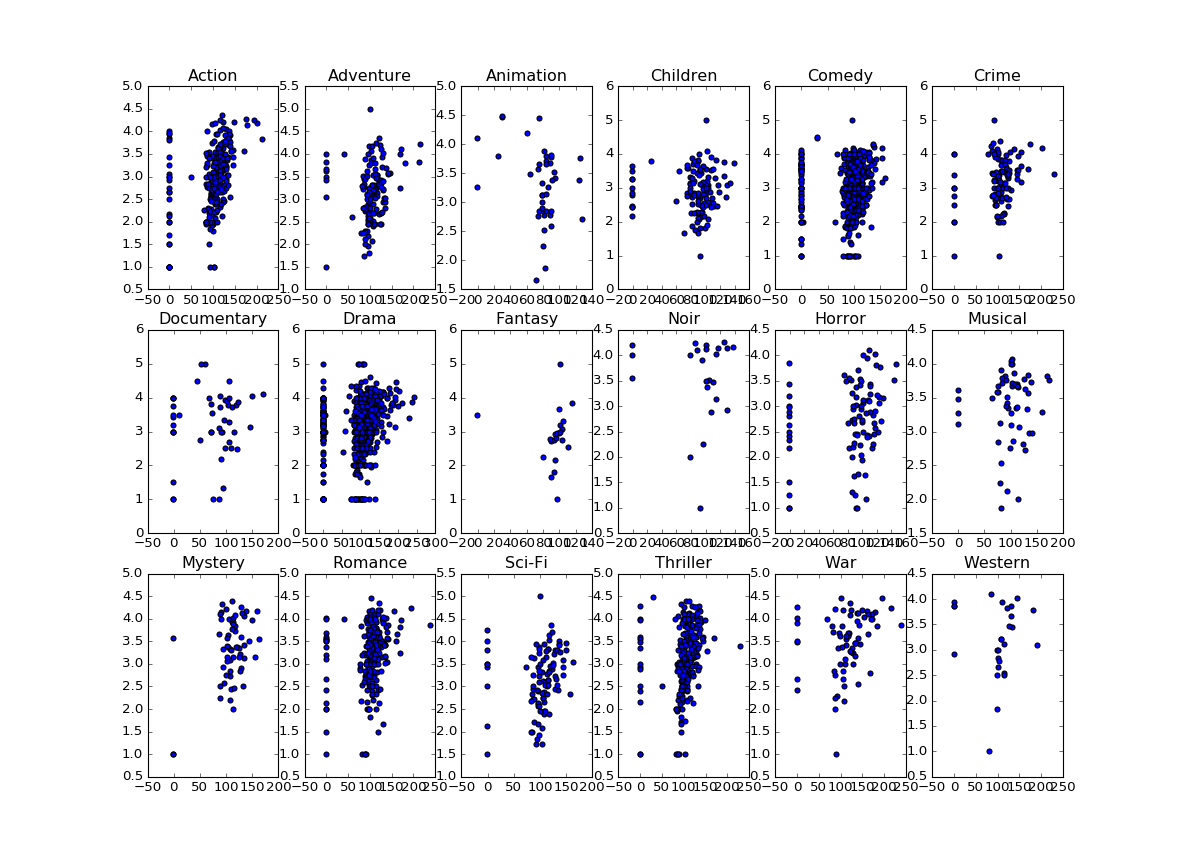

In [287]:
genres = item.columns.values[5:23]
Axes.set_default_color_cycle
for n, g in enumerate(genres):
    plt.subplot(3, 6, n+1)
    plt.scatter(raw_score['Runtime'].loc[raw_score[g]==1], raw_score['Rating'].loc[raw_score[g]==1])
    plt.title(g)
